In [1]:
import sys
sys.path.append('..')

import copy
import json
import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import noise
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from datasets import imagenet2012_handler

# Dataset Processor

In [ ]:
class DatasetProcessor:
  def __init__(self, root, test_split=0.1, val_split=0.1):
    self._root = root
    self._test_split = test_split
    self._val_split = val_split
    
    self._build_synset_lookup()
    self._set_df_path()
    
    if os.path.exists(self._df_path):
      self.df = pd.read_csv(self._df_path)
    else:
      self._setup_df()
      self.df = self._create_split_df()
      self.df.to_csv(self._df_path, index=False)
      
  def _set_df_path(self):
    df_root = os.path.join(self._root, 'split_dfs')
    if not os.path.exists(df_root):
      os.makedirs(df_root)
    df_basename = f'df__test_split_{test_split}__val_split_{val_split}.csv'
    self._df_path = os.path.join(df_root, df_basename)
    
  def _create_split_df(self):
    unique_synset_idx = np.unique([os.path.basename(os.path.dirname(ele)) 
                                   for ele in self.df.img_path])

    dfs = []
    for i, synset_id in enumerate(unique_synset_idx):
      sys.stdout.write((f'\rProcessing Synset id: {synset_id} '
                        f'[{i+1}/{len(unique_synset_idx)}]'))
      sys.stdout.flush()

      df = self.df[self.df.img_path.str.contains(synset_id)]
      df = df.sample(frac=1).reset_index(drop=True)

      num_test = int(len(df) * self._test_split)
      num_dev = len(df) - num_test

      num_val = int(num_dev * self._val_split)
      num_train = num_dev - num_val

      test_df = df.iloc[:num_test]
      val_df = df.iloc[num_test:num_test+num_val]
      train_df = df.iloc[num_test+num_val:]

      test_df['set'] = 'test'
      val_df['set'] = 'val'
      train_df['set'] = 'train'

      synset_df = pd.concat([train_df, test_df, val_df])

      dfs.append(synset_df)

    dfs = pd.concat(dfs)
    return dfs
    
  def _setup_df(self):
    dataset_root = os.path.join(self._root, 
                                'ILSVRC/Data/CLS-LOC', 
                                'train')
    
    img_paths = glob.glob(f'{dataset_root}/*/*')
    
    self.df = pd.DataFrame({"img_path": img_paths})
    self.df['synset_id'] = [os.path.basename(os.path.dirname(ele))
                            for ele in self.df.img_path]
    self.df['class'] = [self.synset_lookup[ele] for ele in self.df.synset_id]
    
    sorted_keys = np.sort(list(self.synset_lookup.keys()))
    synset_to_labels = {k: i for i, k in enumerate(sorted_keys)}
    self.df['label'] = [synset_to_labels[ele] for ele in self.df.synset_id]
    
  def _build_synset_lookup(self):
    synset_map = os.path.join(root, 'LOC_synset_mapping.txt')
    self.synset_lookup = {}
    with open(synset_map, 'r') as infile:
      for line in infile:
        line = line.strip()
        k = line.split(" ")[0]
        v = " ".join(line.split(" ")[1:])
        self.synset_lookup[k] = v

In [3]:
test_split = 0.1
val_split = 0.1
root = '/hdd/mliuzzolino/datasets/ImageNet2012'

In [4]:
# data_processor = DatasetProcessor(root)

In [5]:
hand = imagenet2012_handler.create_datasets(os.path.dirname(root))

In [6]:
train_ds = hand['train']

In [7]:
train_handler = DataLoader(train_ds, batch_size=128, num_workers=1, shuffle=True)

In [8]:
for i, (X, y) in enumerate(train_handler):
  sys.stdout.write(f'\rBatch {i+1}/{len(train_handler)}')
  sys.stdout.flush()
  break

Batch 1/8109

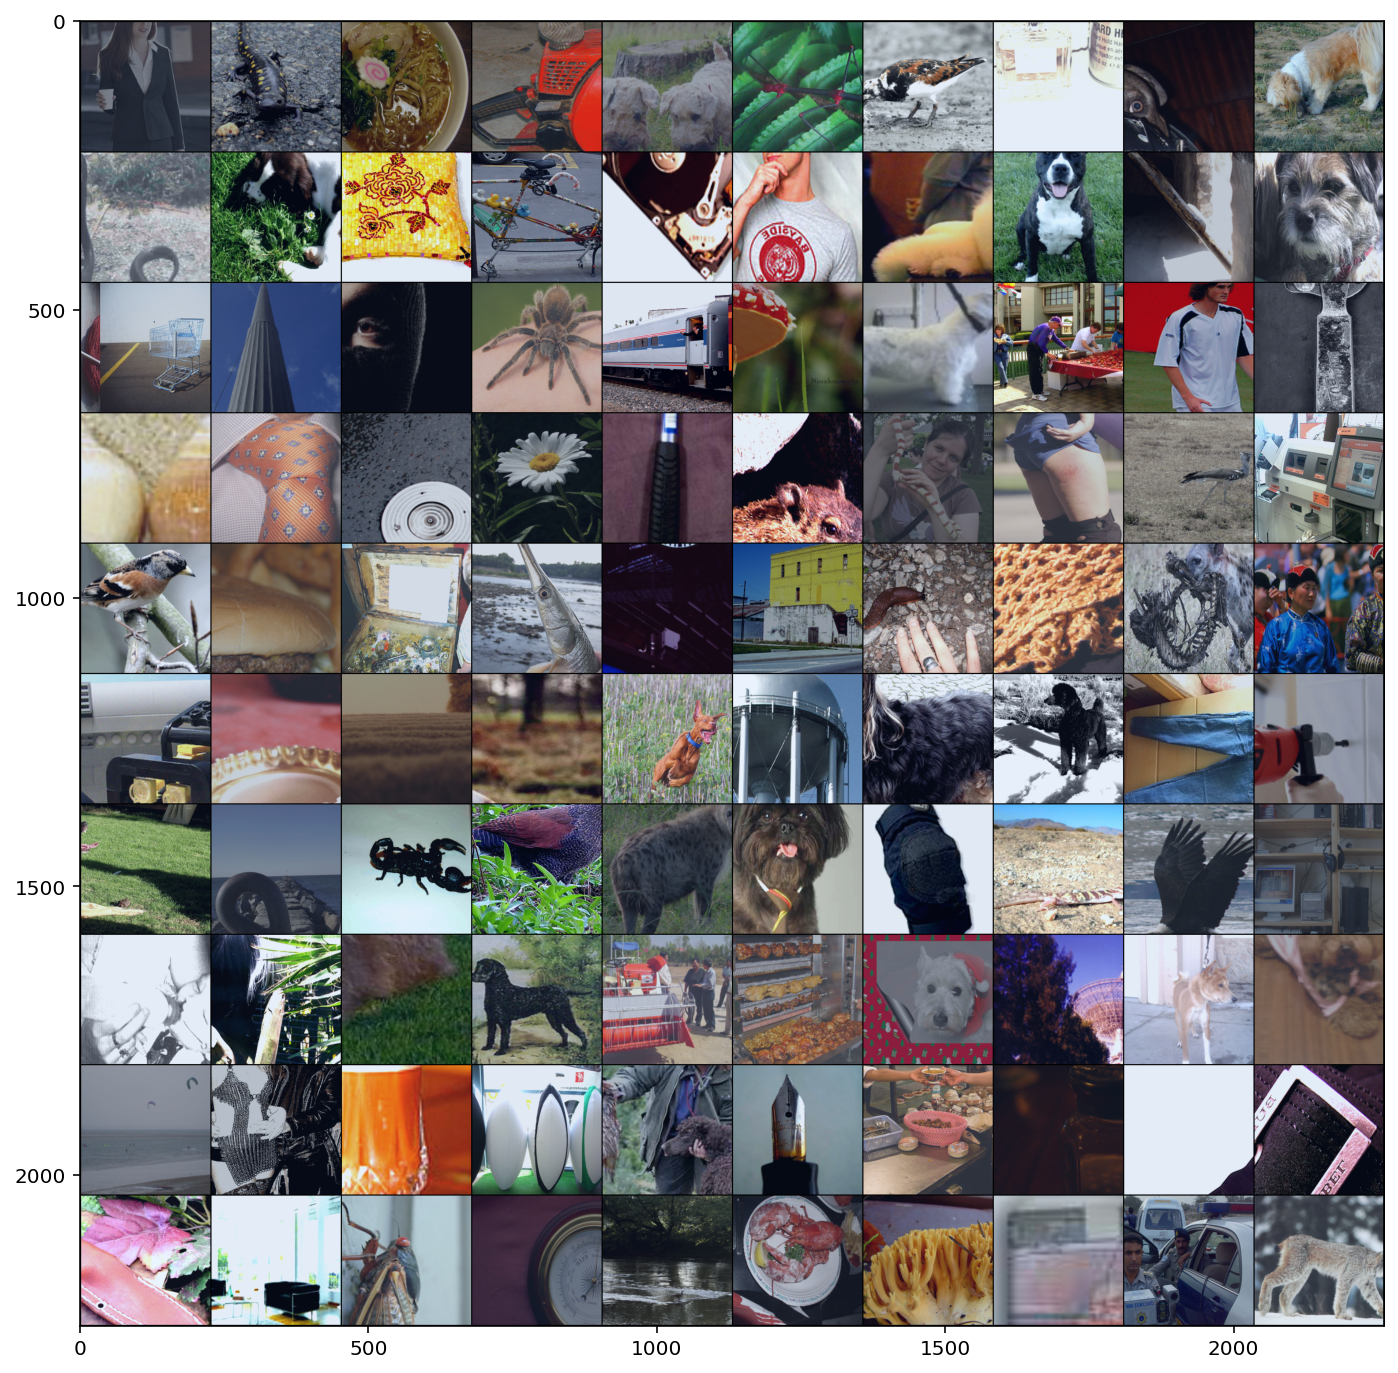

In [9]:
nrow = 10
rand_idxs = np.random.choice(range(X.shape[0]), nrow**2, replace=False)
grid_im = make_grid(X[rand_idxs], normalize=True, nrow=nrow).permute(1,2,0)

plt.figure(figsize=(12,12))
plt.imshow(grid_im)

# Dataset Class

In [ ]:
class ImageNetHandler(Dataset):
  """Imagenet dataset handler."""
  def __init__(self, root, dataset_key, transform=None, test_split=0.1, val_split=0.1):
    super().__init__()
    self._root = root
    self._dataset_key = dataset_key
    self._transform = transform
    self._test_split = test_split
    self._val_split = val_split
    
    self._load_df()
  
  def _load_df(self):
    df_root = os.path.join(self._root, 'split_dfs')
    df_basename = (f'df__test_split_{self._test_split}__'
                   f'val_split_{self._val_split}.csv')
    df_path = os.path.join(df_root, df_basename)
    if not os.path.exists(df_path):
      print(f'{df_path} does not exist.')
      print('Options: ')
      for path in os.listdir(os.path.dirname(df_path)):
        print(path)
      return
    
    df = pd.read_csv(df_path)
    self.df = df[df.set==self._dataset_key]
    
  def __len__(self):
    return len(self.df.img_path)
  
  def __getitem__(self, index):
    df_i = self.df.iloc[index]
    
    # Load iamge
    img = Image.open(df_i.img_path)

    if self._transform is not None:
      img = self._transform(img)

    # Grab target
    target = df_i.label
    cls_label = df_i['class']
    
    return img, target, cls_label

In [ ]:
root = '/hdd/mliuzzolino/datasets/ImageNet2012'

In [ ]:
class EnsureShape:
  def __init__(self, n_channels=3):
    self._n_channels = n_channels
    
  def __call__(self, x):
    if x.shape[0] != self._n_channels:
      x = x.repeat(3, 1, 1)
    return x

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.ToTensor(),
    EnsureShape(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

eval_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    EnsureShape(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

train_ds = ImageNetHandler(root, dataset_key='train', transform=train_transforms)
val_ds = ImageNetHandler(root, dataset_key='val', transform=eval_transforms)
test_ds = ImageNetHandler(root, dataset_key='test', transform=eval_transforms)

In [ ]:
train_handler = DataLoader(train_ds, batch_size=128, shuffle=True)
val_handler = DataLoader(val_ds, batch_size=128, shuffle=False)
test_handler = DataLoader(test_ds, batch_size=128, shuffle=False)

In [ ]:
for X, y, z in train_handler:
  break

In [ ]:
z[1]

In [ ]:
X.shape, y.shape, z.shape

In [ ]:
nrow = 10
rand_idxs = np.random.choice(range(X.shape[0]), nrow**2, replace=False)
grid_im = make_grid(X[rand_idxs], normalize=True, nrow=nrow).permute(1,2,0)

plt.figure(figsize=(12,12))
plt.imshow(grid_im)